In [21]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from skimage.color import rgb2gray
import pickle

In [22]:
def plot_image_grid(images, title, image_shape=(64,64),n_col=5, n_row=2, bycol=0, row_titles=None,col_titles=None):
    fig,axes = plt.subplots(nrows=n_row,ncols=n_col,figsize=(2. * n_col, 2.26 * n_row))
    for i, comp in enumerate(images):
        row,col = reversed(divmod(i,n_row)) if bycol else divmod(i,n_col)       
        cax = axes[row,col]
        cax.imshow(comp.reshape(image_shape), cmap='gray',
                   interpolation='nearest',
                   vmin=comp.min(), vmax=comp.max())
        cax.set_xticks(())
        cax.set_yticks(())
    if row_titles is not None :
        for ax,row in zip(axes[:,0],row_titles) :
            ax.set_ylabel(row,size='large')
    if col_titles is not None :
        for ax,col in zip(axes[0],col_titles) :
            ax.set_title(col)
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(title + '.pdf',bbox_inches='tight')
    plt.show()

In [23]:
def make_pyramids(images_list,num_levels):
    '''
    return struct: list_1 of list_2 of arrays
    list_2 has length equal to num_levels, and contains num_levels amount of pyramids
    list_1 has length equal to len(images_list)
    
    Access the return by all_pyramids_list[image_index][level_index]
    '''
    all_pyramids_list = []
    for image in images_list:
        prev_level = image
        one_pyramid_list = [image]
        for ii in range(num_levels):
            im_down = cv2.pyrDown(prev_level)
            prev_level = im_down
            one_pyramid_list.append(im_down)
        all_pyramids_list.append(one_pyramid_list)
    return all_pyramids_list
            

In [24]:
def PCA_pyramids(all_pyramids_list):
    '''
    for each level in each image pyramid, do a PCA on it, and store the principal components.
    
    !!ONLY HANDLES SQUARE IMAGES!!
    '''
    num_pyramids = len(all_pyramids_list)
    num_pixels = all_pyramids_list[0][0].shape[0]*all_pyramids_list[0][0].shape[1]
    num_levels = len(all_pyramids_list[0])
    eig_vals_vecs_per_level = []
    for level_idx in range(num_levels):
        num_pixels = all_pyramids_list[0][level_idx].shape[0]*all_pyramids_list[0][level_idx].shape[1]
        X = np.zeros((num_pyramids,num_pixels))

        for img_idx in range(num_pyramids):
            image = all_pyramids_list[img_idx][level_idx]
            #We "ravel" the image into a 1d array, we will have to unravel it later
            X[img_idx,:] = np.reshape(image,(-1,num_pixels))
        #Perform PCA on X
        cov = (X-X.mean(axis=0)).T@(X-X.mean(axis=0))
        eig_vals,eig_vecs = np.linalg.eigh(cov)
        #unravel each eigenvector
        new_eigvec_list = []
        for ii in range(len(eig_vecs)):
            num_pixels_per_side = int(num_pixels**.5)#this is square root of total pixels
            new_eig_vec = np.reshape(eig_vecs[:,ii],(num_pixels_per_side,num_pixels_per_side),'F')
            new_eigvec_list.append(new_eig_vec.T) # have to transpose for some reason? this isnt a good sign
        eig_vals_vecs_per_level.append((eig_vals,new_eigvec_list))
        
    return eig_vals_vecs_per_level


            

# Olivetti Faces


In [25]:
data = fetch_olivetti_faces()
labels = data.target
data.keys()
im = data.images

In [26]:
im.shape

(400, 64, 64)

In [27]:
all_pyramids_list = make_pyramids(data.images,3)
eig_vals_vecs_per_level = PCA_pyramids(all_pyramids_list)

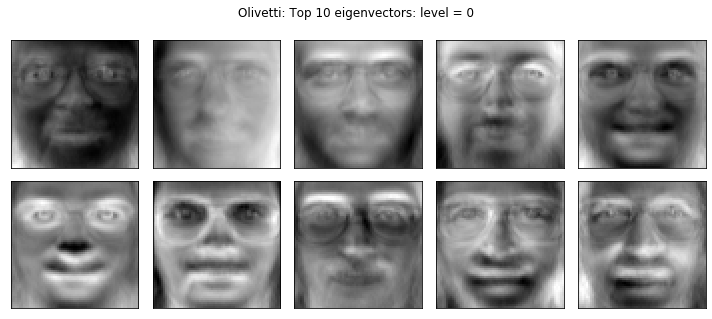

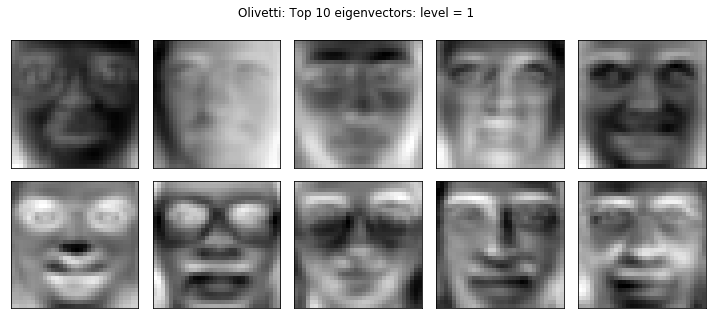

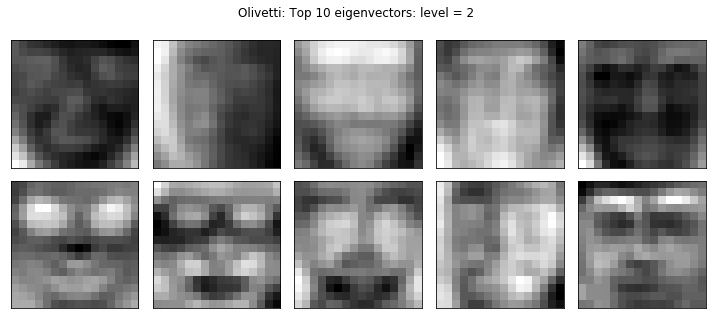

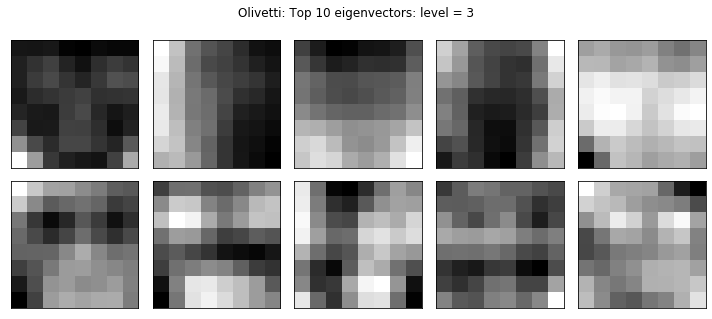

In [28]:
for level,(eig_vals,eig_vecs) in enumerate(eig_vals_vecs_per_level):
    #eig_vals is sorted from lowest to highest
    #Take top 10 eigenvectors
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Olivetti: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)

In [33]:
pickle.dump(eig_vals_vecs_per_level, open('olivetti_pyramids.p','wb'))

## Note that the first result matches Homework 2, eigenfaces, problem c

# CelebA 

In [ ]:
input_image_dir = '../celebA_output/'
original_images_path_list = []
reconstructed_images_path_list = []

for file in os.listdir(input_image_dir):
    if file.endswith("orig.png"):
        original_images_path_list.append(file)
for file in os.listdir(input_image_dir):
    if file.endswith("recons.png"):
        reconstructed_images_path_list.append(file)
original_images = [rgb2gray(plt.imread(input_image_dir+file)) for file in original_images_path_list]

    

In [ ]:
all_pyramids_list = make_pyramids(original_images,3)
eig_vals_vecs_per_level = PCA_pyramids(all_pyramids_list)

In [ ]:
for level, (eig_vals,eig_vecs) in enumerate(eig_vals_vecs_per_level):
    #eig_vals is sorted from lowest to highest
    #Take top 10 eigenvectors
    images = eig_vecs[-10:]
    images = np.flipud(images)
    plot_title = "CelebA Top 10 eigenvectors: " + level
    plot_image_grid(images,'Top 10 eigenvectors',image_shape=eig_vecs[0].shape)

In [ ]:
pickle.dump('eig_vals_vecs_per_level', 'celebA_pyramids.p')

[(array([-1.41353731e-12, -1.40015618e-12, -1.36998377e-12, ...,
          2.51554128e+03,  4.41763307e+03,  7.51723014e+03]),
  [array([[ 0.00000000e+00, -3.84156310e-02, -6.12270896e-02, ...,
           -9.51498479e-03,  4.61404808e-03, -6.57324626e-04],
          [ 6.34915626e-05,  3.15033598e-03,  1.58196396e-02, ...,
            1.27780968e-02, -2.88121564e-04,  1.02230922e-02],
          [ 5.52408916e-03,  1.50172760e-02,  2.64711230e-02, ...,
           -2.79652237e-03, -1.61366208e-02,  1.37898205e-02],
          ...,
          [ 1.39799260e-02,  5.81996797e-03,  4.99732823e-03, ...,
           -6.67395698e-03,  6.28435972e-03, -3.08980945e-03],
          [-1.26452537e-02,  4.61857434e-03, -7.91476594e-03, ...,
           -2.16751415e-02,  1.30530081e-02,  1.03517432e-02],
          [ 2.80084498e-03, -2.15769792e-03, -8.75551145e-03, ...,
            7.38172399e-03, -1.15825872e-02, -8.68637023e-03]]),
   array([[ 0.        , -0.06288527, -0.02011939, ..., -0.00437829,
        